# 导入模型

In [1]:
import torch
import torch.nn as nn
# 定义一个从股票历史数据中提取风险因子的神经网络模型
class TtRiskFactor(nn.Module):
    def __init__(self,
                 features_size,
                 hidden_size,
                 risk_factor_size,
                 num_layers,
                 stock_size):
        super().__init__()
        self.features_size = features_size  # 特征尺寸
        self.hidden_size = hidden_size  # 隐藏层尺寸
        self.risk_factor_size = risk_factor_size  # 风险因子尺寸
        self.num_layers = num_layers  # GRU层数
        self.stock_size = stock_size  # 股票数量
        # 定义GRU层
        self.gru = nn.GRU(input_size=features_size,
                          hidden_size=hidden_size,
                          num_layers=num_layers,
                          batch_first=True)
        # 定义全连接层
        self.FC = nn.Linear(in_features=hidden_size * num_layers,
                            out_features=risk_factor_size)
        # 定义批量归一化层
        self.norm = nn.BatchNorm1d(num_features=stock_size)
    def forward(self, input_tensor: torch.Tensor) -> torch.Tensor:
        input_tensor = input_tensor
        period_size = input_tensor.shape[1]  # 获取输入张量的时间步长
        # 转换输入张量的形状
        input_tensor_ = input_tensor.permute((0, 2, 1, 3)).contiguous().view(-1,
                                                                             period_size,
                                                                             self.features_size)
        input_tensor_ = input_tensor_
        # 通过GRU层处理数据
        _, hidden = self.gru(input_tensor_)
        # 转换隐藏层输出形状
        hidden_ = self.FC(hidden.view(-1, self.stock_size, self.hidden_size*self.num_layers))
        # 进行批量归一化
        Tt_risk_factors = self.norm(hidden_)
        return Tt_risk_factors

In [2]:
import torch
import torch.nn as nn
from typing import Tuple
# 定义了一个图注意力网络（GAT）模型，用于生成风险因子，在其他文件中被引用
class GraphAttentionNetworks(nn.Module):
    def __init__(self,
                 features_size,
                 dropout):
        super().__init__()
        self.features_size = features_size  # 特征尺寸
        self.dropout = dropout  # dropout 概率
        # 定义线性投影层
        self.proj = nn.Linear(in_features=features_size,
                              out_features=features_size,
                              bias=False)
        # 定义Dropout层
        self.dropout = nn.Dropout(dropout)
        # 定义缩放因子
        self.scale = torch.sqrt(torch.Tensor([features_size]).to(device))
        # 定义LeakyReLU激活函数
        self.leakyRelu = nn.LeakyReLU()
    def forward(self,
                query: torch.Tensor,
                key: torch.Tensor,
                value: torch.Tensor,
                mask=None) -> Tuple[torch.Tensor, torch.Tensor]:
        batch_size, stock_size = query.shape[0], query.shape[2]  # 获取批量大小和股票数量
        # 线性投影操作
        Q, K, V = self.proj(query), self.proj(key), self.proj(value)
        # 计算注意力打分
        a = torch.matmul(Q, K.permute(0, 1, 3, 2))/self.scale  # 使用缩放点积模型
        if mask is not None:
            a = a.masked_fill(mask == 0, -1e10)  # 应用掩码
        # 计算注意力分布
        e = self.leakyRelu(a)
        attention_distribution = torch.softmax(e, dim=-1)
        # 计算输出
        output = self.leakyRelu(torch.matmul(self.dropout(attention_distribution), V))
        return output, attention_distribution

In [3]:
# 使用GAT和GRU这两种RNN来从股票的历史序列数据中生成风险因子，使用了Graph_Attention_Networks中定义的网络
class CStRiskFactor(nn.Module):
    def __init__(self,
                 features_size,
                 hidden_size,
                 risk_factor_size,
                 num_layers,
                 stock_size,
                 dropout):
        super().__init__()
        self.features_size = features_size  # 特征尺寸
        self.hidden_size = hidden_size  # 隐藏层尺寸
        self.risk_factor_size = risk_factor_size  # 风险因子尺寸
        self.num_layers = num_layers  # GRU层数
        self.stock_size = stock_size  # 股票数量
        # 初始化图注意力网络（GAT）
        self.gat = GraphAttentionNetworks(features_size=features_size,
                                          dropout=dropout)
        # 初始化GRU网络
        self.gru = TtRiskFactor(features_size=features_size,
                                hidden_size=hidden_size,
                                risk_factor_size=risk_factor_size,
                                num_layers=num_layers,
                                stock_size=stock_size)
    def forward(self, input_tensor: torch.Tensor) -> torch.Tensor:
        # 使用GAT网络处理输入张量
        gat_output, _ = self.gat(input_tensor, input_tensor, input_tensor)
        # 将GAT输出从输入张量中减去
        input_tensor_ = input_tensor - gat_output
        # 使用GRU网络处理调整后的输入张量
        CSt_risk_factors = self.gru(input_tensor_)
        return CSt_risk_factors

In [4]:
# 最终的模型
import torch
import torch.nn as nn
# 从历史数据中提取风险因子，使用了一个比较复杂的RNN来做这件事，但是参数需要自行设定
class RiskFactorExtraction(nn.Module):
    def __init__(self,
                 features_size,
                 hidden_size,
                 risk_factor_size,
                 num_layers,
                 stock_size,
                 dropout):
        super().__init__()
        self.features_size = features_size  # 特征尺寸
        self.hidden_size = hidden_size  # 隐藏层尺寸
        self.risk_factor_size = risk_factor_size  # 风险因子尺寸
        self.num_layers = num_layers  # GRU层数
        self.stock_size = stock_size  # 股票数量
        # 初始化 TtRiskFactor 层
        self.TtLayer = TtRiskFactor(features_size=features_size,
                                    hidden_size=hidden_size,
                                    risk_factor_size=risk_factor_size,
                                    num_layers=num_layers,
                                    stock_size=stock_size)
        # 初始化 CStRiskFactor 层
        self.CStLayer = CStRiskFactor(features_size=features_size,
                                      hidden_size=hidden_size,
                                      risk_factor_size=risk_factor_size,
                                      num_layers=num_layers,
                                      stock_size=stock_size,
                                      dropout=dropout)
        # 定义线性投影层
        self.proj = nn.Linear(in_features=risk_factor_size,
                              out_features=risk_factor_size,
                              bias=False)
        # 定义批量归一化层
        self.norm = nn.BatchNorm1d(num_features=stock_size)
    def forward(self, input_tensor: torch.Tensor) -> torch.Tensor:
        # 使用 TtRiskFactor 层处理输入张量
        Tt_Risk_Factors = self.norm(self.proj(self.TtLayer(input_tensor)))
        # 使用 CStRiskFactor 层处理输入张量
        CSt_risk_Factors = self.norm(self.proj(self.CStLayer(input_tensor)))
        # 将 Tt_Risk_Factors 和 CSt_risk_Factors 拼接在一起
        risk_factors = torch.cat((Tt_Risk_Factors, CSt_risk_Factors), dim=-1)
        return risk_factors

In [5]:
import torch
import torchmetrics
import operator
from typing import *
from functools import reduce
from itertools import accumulate
from torch import mean, linalg, square, matmul, trace
# 设置随机种子，确保结果的可重复性
torch.manual_seed(seed=13)
# 这个类可以在训练因子模型时，平衡解释方差和方差膨胀因子，从而构建更稳定和解释性更强的金融模型
# 计算因子模型的损失，衡量这个因子模型的表现
class FactorLoss(torchmetrics.Metric):
    # 指定这个指标是越低越好
    higher_is_better = False
    # 表示是否在每次 update 时更新完整的状态
    full_state_update = False
    def __init__(self, gamma):
        super().__init__()
        # 初始化解释方差状态
        self.add_state(name='explained_variance',
                       default=torch.tensor(0.0),  # 可以是 Tensor 或 空列表
                       dist_reduce_fx='sum')  # 'sum', 'mean', 'cat', 'min' 或 'max'
        # 初始化方差膨胀因子（VIF）状态
        self.add_state(name='vif',
                       default=torch.tensor(0.0),
                       dist_reduce_fx='sum')
        # Gamma 用于平衡解释方差和方差膨胀因子
        self.gamma = gamma
    # 更新状态的函数
    def update(self, factors: torch.Tensor, returns: torch.Tensor):
        T, H = returns.shape[0:2]  # 获取返回值的时间长度和股票数量
        # 计算解释比例的内部函数
        def explained_ratio(n):
            # 创建一个矩阵列表，用于计算解释比例
            matrix_list = [factors,
                           linalg.inv(matmul(factors.permute(0, 2, 1), factors)),
                           factors.permute(0, 2, 1),
                           returns.permute(1, 0, 2, 3)[n]]
            # 计算偏差
            dev = returns.permute(1, 0, 2, 3)[n] - reduce(operator.matmul, matrix_list)
             # 打印调试信息
            # print("returns.permute(1, 0, 2, 3)[n].shape:", returns.permute(1, 0, 2, 3)[n].shape)
            # print("reduce(operator.matmul, matrix_list).shape:", reduce(operator.matmul, matrix_list).shape)
            # 返回解释比例
            return mean(square(linalg.norm(dev, ord=2, dim=(1, 2)))) / \
                   mean(square(linalg.norm(matrix_list[-1], ord=2, dim=(1, 2))))
        # 更新解释方差
        self.explained_variance += reduce(operator.add, map(lambda h: explained_ratio(h), range(H))) / H
        # 更新方差膨胀因子
        self.vif += reduce(operator.add, map(lambda t: trace(
            linalg.inv(matmul(factors.permute(0, 2, 1), factors))[t]), range(T))) / T
    # 计算最终的损失值
    def compute(self) -> torch.Tensor:
        return self.explained_variance + self.gamma * self.vif

# 实际运行

In [6]:
import pickle

# 从本地文件读取变量
with open('../tt/new_data.pkl', 'rb') as f:
    dataX, dataY = pickle.load(f)

In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# 检查是否有GPU可用
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [8]:
dataX.size()

torch.Size([2547, 2, 63, 50, 6])

In [9]:
dataY.size()

torch.Size([2547, 2, 1, 50, 2])

In [10]:
# 检查输入数据
def check_for_nan(tensor, name = ''):
    if torch.isnan(tensor).any():
        print(f"NaN detected in {name}")
    if torch.isinf(tensor).any():
        print(f"Inf detected in {name}")

In [11]:
check_for_nan(dataX)

In [12]:
check_for_nan(dataY)

In [13]:
stock_n = 50

In [14]:
X_point = int(len(dataX) * 0.8)
Y_point = int(len(dataY) * 0.8)

train_X = dataX[:X_point]
test_X = dataX[X_point:]
train_Y = dataY[:Y_point]
test_Y = dataY[Y_point:]

In [15]:
train_X.size()

torch.Size([2037, 2, 63, 50, 6])

In [16]:
train_Y.size()

torch.Size([2037, 2, 1, 50, 2])

In [17]:
# 步骤2：定义模型
model = RiskFactorExtraction(
    features_size=6, # 要和特征的数量一样
    hidden_size=64,
    risk_factor_size=2, # 要和factor的数量一样
    num_layers=6,
    stock_size=stock_n, # 要和股票的数量一样
    dropout=0.5
).to(device) # 将模型转移到GPU

# 步骤3：定义优化器
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# 步骤4：定义损失函数
loss_fun = FactorLoss(gamma=0.01).to(device) # 将损失函数转移到GPU

In [18]:
from torch.optim.lr_scheduler import StepLR
scheduler = StepLR(optimizer, step_size=10, gamma=0.5) # 动态学习率

In [19]:
import matplotlib.pyplot as plt

num_epochs = 60
train_losses = []
val_losses = []
learning_rates = []
cov = []
for epoch in range(num_epochs):
    # 训练过程
    model.train()
    total_train_loss = 0.0
    for batch_features, batch_returns in zip(train_X, train_Y):
        batch_features = batch_features.to(device)
        batch_returns = batch_returns.to(device)
        optimizer.zero_grad()
        factors = model(batch_features)  # 生成因子
        loss = loss_fun(factors, batch_returns)  # 评估
        loss.backward()
        optimizer.step()
        total_train_loss += loss.item()
    
    avg_train_loss = total_train_loss / len(train_X)
    train_losses.append(avg_train_loss)
    
    # 验证过程
    model.eval()
    total_val_loss = 0.0
    with torch.no_grad():
        for val_features, val_returns in zip(test_X, test_Y):
            val_features = val_features.to(device)
            val_returns = val_returns.to(device)
            factors = model(val_features)  # 生成因子
            cov_sum = torch.zeros(stock_n, stock_n).to(device)

            # 计算每个 639x4 矩阵的协方差矩阵并累加
            for i in range(factors.size(0)):
                mat = factors[i]  # 取出第 i 个 nx4 的矩阵
                cov_matrix = torch.mm(mat, mat.t())  # 计算协方差矩阵 nxn
                cov_sum += cov_matrix.to(device)  # 累加协方差矩阵

            # 计算协方差矩阵的平均值
            cov_mean = cov_sum / factors.size(0)#这个就是我们想要的covariance矩阵
            cov.append(cov_mean)
            # print(cov_mean)
            # print(cov_mean.size())
            val_loss = loss_fun(factors, val_returns)  # 评估
            total_val_loss += val_loss.item()
    
    avg_val_loss = total_val_loss / len(test_X)
    val_losses.append(avg_val_loss)
    current_lr = scheduler.get_last_lr()[0]
    learning_rates.append(current_lr)
    
    print(f"Epoch {epoch+1}, Train Loss: {avg_train_loss}, Val Loss: {avg_val_loss}")
    
    # 更新学习率
    scheduler.step()

Epoch 1, Train Loss: 0.6789025245714433, Val Loss: 0.6858900807651819
Epoch 2, Train Loss: 0.6538641319798089, Val Loss: 0.6482624006037618
Epoch 3, Train Loss: 0.6272598239732655, Val Loss: 0.6333677134969655
Epoch 4, Train Loss: 0.6096307663251561, Val Loss: 0.6308192861138605
Epoch 5, Train Loss: 0.5980401996177497, Val Loss: 0.6328956919557908
Epoch 6, Train Loss: 0.5883646328212527, Val Loss: 0.6290960615756465
Epoch 7, Train Loss: 0.5755949358715985, Val Loss: 0.6223258030619107
Epoch 8, Train Loss: 0.5631571919947614, Val Loss: 0.6122364575372022
Epoch 9, Train Loss: 0.5563963178177646, Val Loss: 0.6059293612399522
Epoch 10, Train Loss: 0.552015150129561, Val Loss: 0.6017985722013548
Epoch 11, Train Loss: 0.5488976202118789, Val Loss: 0.6006095373163036
Epoch 12, Train Loss: 0.5474232053370469, Val Loss: 0.5999988594768094
Epoch 13, Train Loss: 0.5461351020068705, Val Loss: 0.598722086423168
Epoch 14, Train Loss: 0.5446998128739712, Val Loss: 0.5988913346008927
Epoch 15, Train L

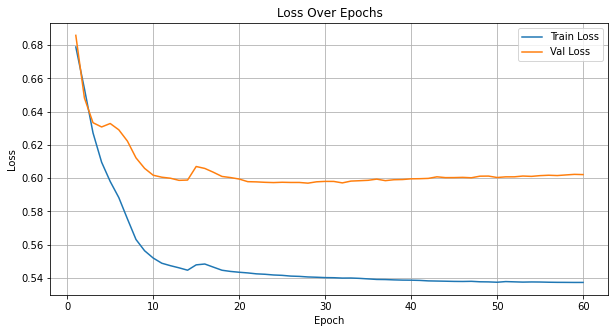

In [20]:
# 绘制训练和验证损失图
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs + 1), val_losses, label='Val Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


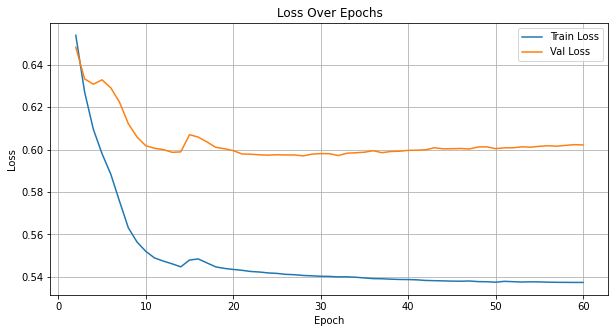

In [21]:
# 绘制训练和验证损失图
plt.figure(figsize=(10, 5))
plt.plot(range(2, num_epochs + 1), train_losses[1:], label='Train Loss')
plt.plot(range(2, num_epochs + 1), val_losses[1:], label='Val Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


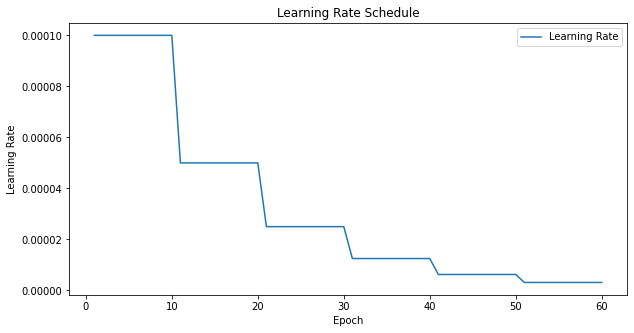

In [22]:
# 绘制学习率变化曲线
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), learning_rates, label='Learning Rate')
plt.xlabel('Epoch')
plt.ylabel('Learning Rate')
plt.title('Learning Rate Schedule')
plt.legend()
plt.show()

In [23]:
cov

[tensor([[ 1.8537,  1.8781,  1.8988,  ..., -0.7896, -0.7019, -1.1040],
         [ 1.8781,  2.0022,  1.9594,  ..., -1.0471, -0.9283, -1.6856],
         [ 1.8988,  1.9594,  1.9591,  ..., -0.8877, -0.7902, -1.3346],
         ...,
         [-0.7896, -1.0471, -0.8877,  ...,  2.4917,  2.1540,  3.2118],
         [-0.7019, -0.9283, -0.7902,  ...,  2.1540,  1.8860,  2.8421],
         [-1.1040, -1.6856, -1.3346,  ...,  3.2118,  2.8421,  5.2000]],
        device='cuda:0'),
 tensor([[ 2.0952,  2.0457,  1.9991,  ..., -1.0731, -0.9726, -1.6515],
         [ 2.0457,  2.0140,  1.9421,  ..., -1.0873, -0.9813, -1.7595],
         [ 1.9991,  1.9421,  1.9269,  ..., -0.8668, -0.7852, -1.3058],
         ...,
         [-1.0731, -1.0873, -0.8668,  ...,  2.5672,  2.2536,  3.3593],
         [-0.9726, -0.9813, -0.7852,  ...,  2.2536,  2.0067,  3.0348],
         [-1.6515, -1.7595, -1.3058,  ...,  3.3593,  3.0348,  5.4869]],
        device='cuda:0'),
 tensor([[ 2.1196,  2.0450,  2.0720,  ..., -1.1489, -1.0087, -1.71

In [24]:
# 现在已经训练好了模型，计算cov的值
cov = []
# 验证过程
model.eval()
total_val_loss = 0.0
with torch.no_grad():
    for val_features, val_returns in zip(test_X, test_Y):
        val_features = val_features.to(device)
        val_returns = val_returns.to(device)
        factors = model(val_features)  # 生成因子
        cov_sum = torch.zeros(stock_n, stock_n).to(device)

        # 计算每个 639x4 矩阵的协方差矩阵并累加
        for i in range(factors.size(0)):
            mat = factors[i]  # 取出第 i 个 639x4 的矩阵
            cov_matrix = torch.mm(mat, mat.t())  # 计算协方差矩阵 639x639
            cov_sum += cov_matrix.to(device)  # 累加协方差矩阵

        # 计算协方差矩阵的平均值
        cov_mean = cov_sum / factors.size(0)#这个就是我们想要的covariance矩阵
        cov.append(cov_mean)

In [25]:
new_cov_list = []
for i in range(len(cov)):
    new_cov_list.append(cov[i])
    if i != len(cov) - 1:
        new_cov_list.append((cov[i] + cov[i+1]) / 2)
    else:
        new_cov_list.append(cov[i])
len(new_cov_list)

1020

In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize

In [27]:
# 计算组合的预期回报和风险
def portfolio_performance(weights, mean_returns, cov_matrix):
    # 确保 mean_returns 和 cov_matrix 是 NumPy 数组
    if isinstance(mean_returns, torch.Tensor):
        mean_returns = mean_returns.cpu().numpy()
    if isinstance(cov_matrix, torch.Tensor):
        cov_matrix = cov_matrix.cpu().numpy()
    
    portfolio_return = np.dot(weights, mean_returns)
    portfolio_std_dev = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    return portfolio_return, portfolio_std_dev

# 计算夏普比率
def negative_sharpe_ratio(weights, mean_returns, cov_matrix, risk_free_rate):
    p_return, p_std_dev = portfolio_performance(weights, mean_returns, cov_matrix)
    return -(p_return - risk_free_rate) / p_std_dev

# 约束条件和边界
def get_portfolio_optimization(mean_returns, cov_matrix, risk_free_rate):
    num_assets = len(mean_returns)
    args = (mean_returns, cov_matrix, risk_free_rate)
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bounds = tuple((0, 1) for asset in range(num_assets))
    result = minimize(negative_sharpe_ratio, num_assets * [1. / num_assets], args=args,
                      method='SLSQP', bounds=bounds, constraints=constraints)
    return result

In [28]:
# 指数的值
data = pd.read_csv('../DL_new/DL_Markowitz/data/return_df.csv')
# 使用上一行的值填充缺失值
df_filled = data.ffill()
# 使用下一行的值填充仍然存在的缺失值
data = df_filled.bfill()

In [29]:
data

,Date,AAPL,MSFT,AMZN,BRK-B,NVDA,JPM,JNJ,UNH,HD,...,HON,LIN,MS,C,UNP,BMY,INTU,GS,UPS,SBUX
0,2002-05-24,-0.041766,-0.028869,0.001028,0.014229,-0.019785,-0.014967,-0.005684,0.005101,0.012048,...,-0.029138,-0.007539,-0.011410,-0.011535,-0.003250,-0.016960,-0.007550,-0.012455,-0.000686,-0.020300
1,2002-05-27,-0.003526,-0.008864,-0.010585,0.001569,-0.020040,-0.007968,-0.001548,0.002428,-0.021887,...,-0.003041,-0.008462,-0.013337,-0.009415,-0.006449,-0.002140,-0.008802,-0.008283,-0.000771,-0.007159
2,2002-05-28,-0.003539,-0.008943,-0.010698,0.001566,-0.020450,-0.008032,-0.001551,0.002422,-0.022376,...,-0.003050,-0.008535,-0.013517,-0.009504,-0.006491,-0.002145,-0.008881,-0.008353,-0.000771,-0.007211
3,2002-05-29,0.000000,-0.005174,-0.007901,-0.018161,0.037058,-0.006202,0.002448,0.011300,-0.014305,...,-0.006662,-0.015335,-0.013376,-0.010974,0.001977,-0.007960,0.034126,-0.009801,0.006326,0.038595
4,2002-05-30,0.009133,0.011271,-0.028972,-0.014447,-0.014717,-0.026310,0.000163,0.014249,-0.019730,...,0.011696,-0.016837,-0.030880,-0.003685,-0.013083,-0.006012,0.035702,-0.014151,0.005609,0.025351
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5087,2021-11-23,0.002419,-0.006347,0.002089,0.012519,-0.006593,0.023631,0.006180,0.021681,-0.001028,...,-0.009859,0.001545,0.025252,0.015247,0.014086,0.007162,0.013511,0.025372,0.004400,0.018931
5088,2021-11-24,0.003278,0.000681,0.000103,-0.004446,0.028813,-0.007875,-0.002804,0.006754,0.009117,...,-0.017702,-0.009125,-0.007291,-0.011674,-0.003118,-0.011203,0.019740,-0.017753,-0.015894,0.003428
5089,2021-11-25,-0.015966,-0.012253,-0.010649,-0.007319,-0.018082,-0.015178,-0.003250,-0.011450,-0.011483,...,-0.009469,-0.010259,-0.015899,-0.013317,-0.013904,-0.002467,-0.012571,-0.012351,-0.007632,-0.014628
5090,2021-11-26,-0.016225,-0.012405,-0.010763,-0.007373,-0.018415,-0.015412,-0.003261,-0.011583,-0.011616,...,-0.009560,-0.010365,-0.016156,-0.013496,-0.014100,-0.002473,-0.012731,-0.012505,-0.007691,-0.014845


In [30]:
import numpy as np
import pandas as pd
from tqdm import tqdm

days = test_X.shape[0] * test_X[0].shape[0]
risk_free_rate = 0.02
today_ev_returns = []
today_p_returns = []
cumulative_ev_returns = []
cumulative_p_returns = []
df = data[-days:].copy()

# 将数据提前转换为列表，减少循环内的转换开销
mean_returns_list = df.iloc[:, 1:].values.tolist()

# 初始化累计收益率
cumulative_ev_return = 0
cumulative_p_return = 0

# 使用 tqdm 包装循环以显示进度条
for day in tqdm(range(days), desc="Processing days"):
    # 计算未来那天的投资组合是什么样子的，使用现在的收益率和预测的未来的协方差矩阵
    cov_matrix = new_cov_list[day]
    now_mean_returns = mean_returns_list[day]
    optimal_risky_portfolio = get_portfolio_optimization(now_mean_returns, cov_matrix, risk_free_rate)
    
    # 提前判断 break 条件，减少不必要的计算
    if day + 21 >= days:
        break

    # 权重和收益率内积得到这一天的 return
    future_mean_returns = mean_returns_list[day + 21]
    today_portfolio_return = np.dot(optimal_risky_portfolio.x, future_mean_returns)
    today_equal_value_return = np.mean(future_mean_returns)
    
    today_ev_returns.append(today_equal_value_return)
    today_p_returns.append(today_portfolio_return)

    # 更新累计收益率
    cumulative_p_return = (cumulative_p_return + 1) * (1 + today_portfolio_return) - 1
    cumulative_ev_return = (cumulative_ev_return + 1) * (1 + today_equal_value_return) - 1

    # 存储累计收益率
    cumulative_p_returns.append(cumulative_p_return)
    cumulative_ev_returns.append(cumulative_ev_return)

# # 打印最终的累计收益率
# print("Cumulative EV Returns:", cumulative_ev_returns)
# print("Cumulative Portfolio Returns:", cumulative_p_returns)

Processing days:  98%|█████████▊| 999/1020 [00:54<00:01, 18.34it/s]


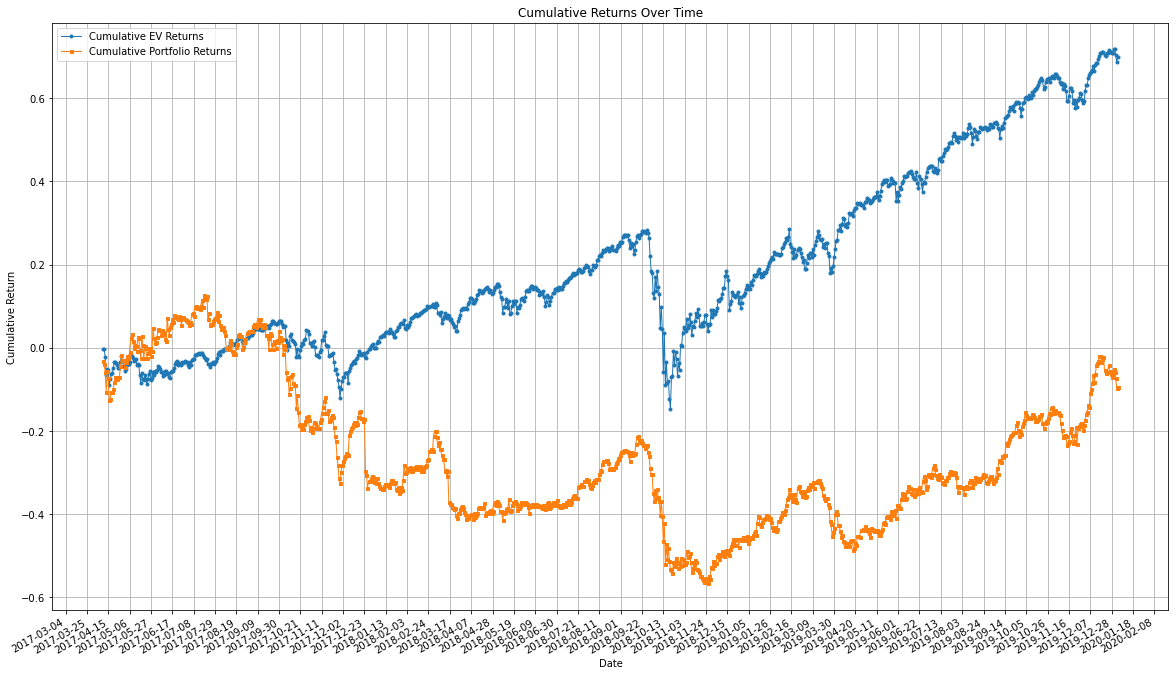

In [31]:
# 绘制累计收益率变化曲线
dates = pd.date_range(start='2017-04-11', periods=days +100, freq='D')
# 绘制累计收益率变化曲线
plt.figure(figsize=(20, 12))
plt.plot(dates[:len(cumulative_ev_returns)], cumulative_ev_returns, label='Cumulative EV Returns', marker='o', markersize=3, linewidth=1)
plt.plot(dates[:len(cumulative_p_returns)], cumulative_p_returns, label='Cumulative Portfolio Returns', marker='s', markersize=3, linewidth=1)
plt.title('Cumulative Returns Over Time')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.legend()
plt.grid(True)
import matplotlib.dates as mdates
# 格式化日期显示，每间隔 21 天显示一次日期
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=21))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gcf().autofmt_xdate()

plt.show()


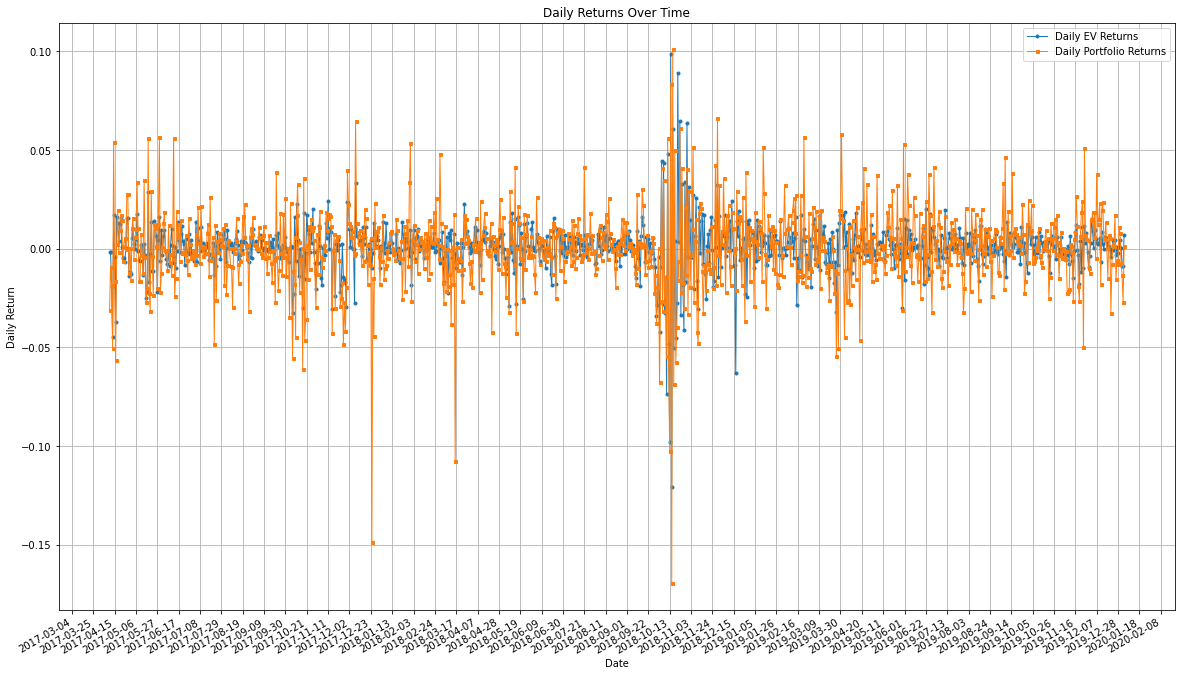

In [32]:
# 绘制每日收益率变化曲线
plt.figure(figsize=(20, 12))
plt.plot(dates[:len(today_ev_returns)], today_ev_returns, label='Daily EV Returns', marker='o', markersize=3, linewidth=1)
plt.plot(dates[:len(today_p_returns)], today_p_returns, label='Daily Portfolio Returns', marker='s', markersize=3, linewidth=1)
plt.title('Daily Returns Over Time')
plt.xlabel('Date')
plt.ylabel('Daily Return')
plt.legend()
plt.grid(True)

# 格式化日期显示，每间隔 21 天显示一次日期
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=21))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gcf().autofmt_xdate()

plt.show()